In [1]:
import pandas as pd
import numpy as np
import sys
import os

In [2]:
coverage_type_dtype = pd.CategoricalDtype(list('NAUR'), ordered=True)

In [3]:
# step1: load all downloaded data

In [4]:
def load_file_preprocess(filename):
    usecols = [
        'CountryCode', 'CountryName', 'CoverageType', 'RequestYear',
        'HeadCount', 'ReqYearPopulation', 'Mean'
    ]
    df = pd.read_csv(filename, usecols=usecols,
                     dtype={'CoverageType': coverage_type_dtype})
    df = df.rename(
        columns={
            'CountryCode': 'country',
            'CoverageType': 'coverage_type',
            'RequestYear': 'year'
        })
    df = df.set_index(['country', 'year', 'coverage_type'])
    return df

In [5]:
res = {}

for f in os.listdir('../source/'):
    if f.endswith('.csv'):
        fn = f.split('.')[0]
        bracket = fn.lstrip('0')
        if bracket == '':
            bracket = 0
        else:
            bracket = int(bracket)
        res[bracket] = load_file_preprocess(os.path.join('../source/', f))
        

In [6]:
res[0]

,,,CountryName,Mean,HeadCount,ReqYearPopulation
country,year,coverage_type,,,,
ALB,1981,N,Albania,220.77280,0.000000,2.726056
DZA,1981,N,Algeria,240.87570,0.000000,19.824301
AGO,1981,N,Angola,166.38240,0.000000,8.640446
ARG,1981,U,Argentina,671.63370,0.002289,23.609667
ARM,1981,N,Armenia,285.08040,0.000130,3.148096
...,...,...,...,...,...,...
VNM,2019,N,Vietnam,348.77690,0.000000,96.462106
PSE,2019,N,West Bank and Gaza,328.30880,0.000000,4.685306
YEM,2019,N,"Yemen, Republic of",70.69390,0.000000,29.161922


In [7]:
# check nans

In [8]:
for k, df in res.items():
    if df['HeadCount'].hasnans:
        print(k)
        print(df[pd.isnull(df['HeadCount'])])

189
                           CountryName  Mean  HeadCount  ReqYearPopulation
country year coverage_type                                                
IND     2018 A                   India   NaN        NaN        1352.617328
             R                   India   NaN        NaN         892.321651
             U                   India   NaN        NaN         460.295677
        2019 A                   India   NaN        NaN        1366.417754
             R                   India   NaN        NaN         895.386226
             U                   India   NaN        NaN         471.031528
178
                           CountryName  Mean  HeadCount  ReqYearPopulation
country year coverage_type                                                
IND     2018 A                   India   NaN        NaN        1352.617328
             R                   India   NaN        NaN         892.321651
             U                   India   NaN        NaN         460.295677
        2019 A   

                           CountryName  Mean  HeadCount  ReqYearPopulation
country year coverage_type                                                
IND     2018 A                   India   NaN        NaN        1352.617328
             R                   India   NaN        NaN         892.321651
             U                   India   NaN        NaN         460.295677
        2019 A                   India   NaN        NaN        1366.417754
             R                   India   NaN        NaN         895.386226
             U                   India   NaN        NaN         471.031528
113
                           CountryName  Mean  HeadCount  ReqYearPopulation
country year coverage_type                                                
IND     2018 A                   India   NaN        NaN        1352.617328
             R                   India   NaN        NaN         892.321651
             U                   India   NaN        NaN         460.295677
        2019 A       

In [9]:
# So all of India 2018/19 are NaNs in it. let's drop them for now

In [10]:
res1 = dict()
for k, df in res.items():
    res1[k] = df.dropna(how='any', subset=['HeadCount'])

In [11]:
# step2: subtract and get bracket head count

In [12]:
res2 = {}

for i in range(1, 200):
    df1 = res1[i]
    df2 = res1[i-1]
    df3 = df1['HeadCount'] - df2['HeadCount']
    res2[i-1] = df3

In [13]:
res2[0]

country  year  coverage_type
ALB      1981  N                0.000000e+00
DZA      1981  N                0.000000e+00
AGO      1981  N                0.000000e+00
ARG      1981  U                3.310000e-07
ARM      1981  N                2.689000e-07
                                    ...     
VNM      2019  N                0.000000e+00
PSE      2019  N                0.000000e+00
YEM      2019  N                0.000000e+00
ZMB      2019  N                0.000000e+00
ZWE      2019  N                0.000000e+00
Name: HeadCount, Length: 6639, dtype: float64

In [14]:
# double check nans

In [15]:
for k, df in res2.items():
    if df.hasnans:
        print(k)
        print(df[pd.isnull(df)])

In [16]:
# ok, looks good

In [17]:
# step 3: create df with bracket info

In [18]:
res3 = []

for k, v in res2.items():
    df = v.reset_index()
    df['bracket'] = k
    df = df.set_index(['country', 'year', 'coverage_type', 'bracket'])
    res3.append(df)

In [19]:
res3 = pd.concat(res3)

In [20]:
res3

,,,,HeadCount
country,year,coverage_type,bracket,
ALB,1981,N,0,0.000000e+00
DZA,1981,N,0,0.000000e+00
AGO,1981,N,0,0.000000e+00
ARG,1981,U,0,3.310000e-07
ARM,1981,N,0,2.689000e-07
...,...,...,...,...
VNM,2019,N,198,0.000000e+00
PSE,2019,N,198,0.000000e+00
YEM,2019,N,198,0.000000e+00


In [21]:
res3['HeadCount'].hasnans

False

In [22]:
# assume each group has 199 datapoints

In [23]:
gs = res3.groupby(['country', 'year', 'coverage_type'])
for g in gs.groups.keys():
    df = gs.get_group(g)
    assert df.shape[0] == 199

In [24]:
# step 4: fix negative values, fix sum of all brackets > 1

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
plt.rcParams['figure.figsize'] = [12, 8]

In [293]:
res4 = res3.copy()

In [294]:
res4.loc[res4['HeadCount'] < 0, 'HeadCount'] = np.nan  # make negative values to nan

In [295]:
# also, drop all big noise. Notes on slack discussion

In [296]:
gs = res4.groupby(['country', 'year', 'coverage_type'])

In [297]:
res5 = list()

In [298]:
for g in gs.groups.keys():
    df = gs.get_group(g)
    s = df['HeadCount'].copy()
    todrop = set()
    if s.hasnans:  # if negative values exists and sum bigger than 1
        where = np.where(pd.isnull(s))[0]
        for w in where:
            todrop.add(w-1)
            todrop.add(w)
            todrop.add(w+1)
        s.iloc[list(todrop)] = np.nan
        res5.append(s)
    else:
        res5.append(s)

In [299]:
res5 = pd.concat(res5)

In [300]:
gs = res5.groupby(['country', 'year', 'coverage_type'])

In [301]:
res5

country  year  coverage_type  bracket
AGO      1981  N              0          0.0
                              1          0.0
                              2          0.0
                              3          0.0
                              4          0.0
                                        ... 
ZWE      2019  N              194        0.0
                              195        0.0
                              196        0.0
                              197        0.0
                              198        0.0
Name: HeadCount, Length: 1321161, dtype: float64

In [338]:
# look for those sum bigger than 1
for g in gs.groups.keys():
    df = gs.get_group(g)
    if df.sum() > 1.1:
        print(g)

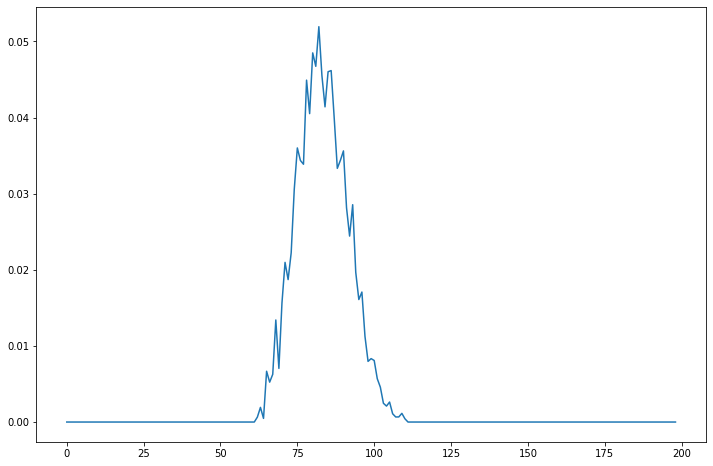

In [304]:
gs = res5.groupby(['country', 'year', 'coverage_type'])
df = gs.get_group(('STP', 1999, 'N'))
plt.plot(df.values)

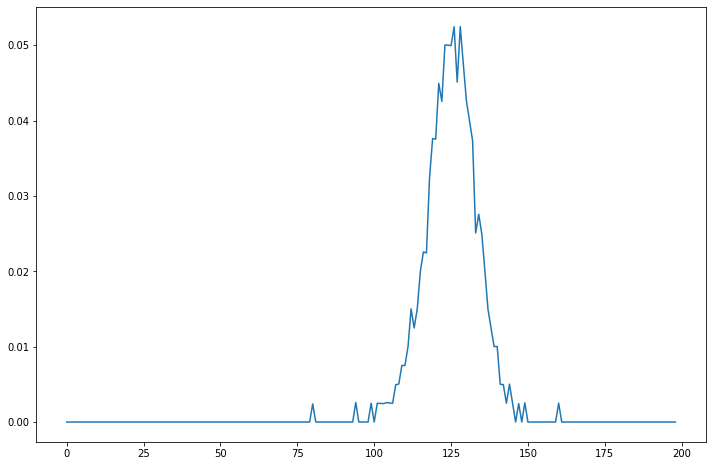

In [305]:
gs = res5.groupby(['country', 'year', 'coverage_type'])
df = gs.get_group(('DEU', 2019, 'N'))
plt.plot(df.values)

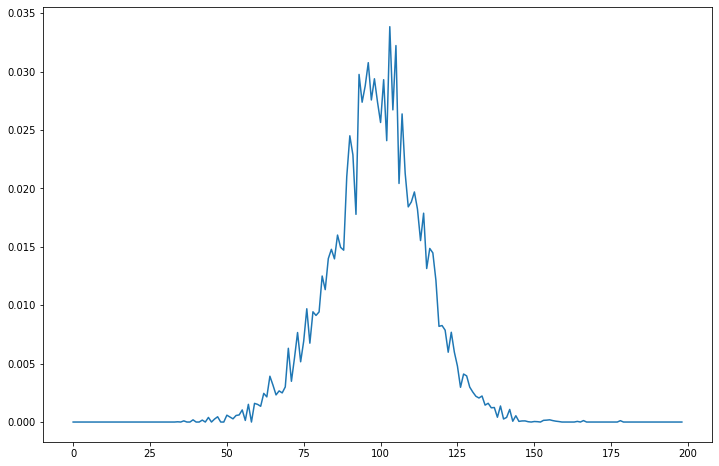

In [306]:
gs = res5.groupby(['country', 'year', 'coverage_type'])
df = gs.get_group(('PRY', 1999, 'N'))
plt.plot(df.values)

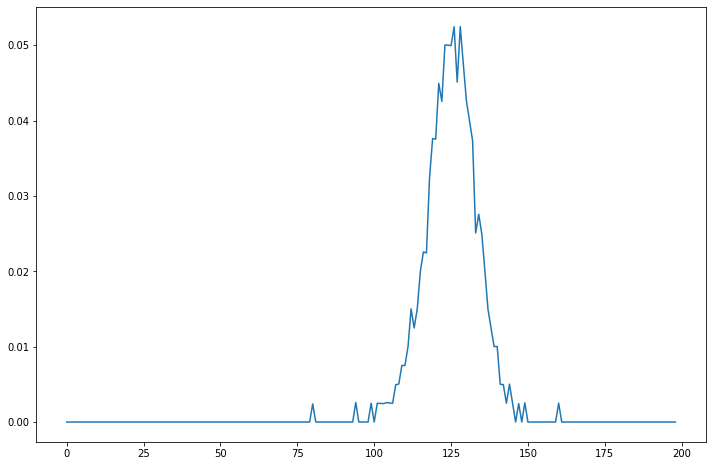

In [40]:
# before smoothing we need to interpolate the values
# now we try if interpolating is ok
gs = res5.groupby(['country', 'year', 'coverage_type'])
df = gs.get_group(('DEU', 2019, 'N'))
plt.plot(df.interpolate().values)

In [41]:
# step 5: smoothing them

In [42]:
sys.path.insert(0, '../scripts')
import smoothlib

In [43]:
run_smooth = smoothlib.run_smooth

In [245]:
def func(x):
    """function to smooth a series"""
    if x.hasnans:
        x = x.interpolate()
        if pd.isnull(x.iloc[0]):
            x = x.fillna(0)
    # x = x.reset_index(drop=True)
    # run smoothing
    std = x.std()
    if std < 0.010:
        res = run_smooth(x, 20, 6)
        res = run_smooth(res, 16, 2)
        res = run_smooth(res, 16, 1)
        res = run_smooth(res, 10, 1)
        res = run_smooth(res, 10, 0)
    elif std < 0.012:
        res = run_smooth(x, 20, 3)
        res = run_smooth(res, 16, 2)
        res = run_smooth(res, 16, 1)
        res = run_smooth(res, 10, 0)
        res = run_smooth(res, 8, 0)
    else:
        res = run_smooth(x, 20, 1)
        res = run_smooth(res, 16, 1)
        res = run_smooth(res, 16, 0)
        res = run_smooth(res, 10, 0)
        res = run_smooth(res, 8, 0)
    # also, make sure it will sum up to 100%
    res = res / res.sum()
    return res

In [307]:
gs = res5.groupby(['country', 'year', 'coverage_type'])

In [334]:
df = gs.get_group(('EGY', 1999, 'N'))
#df = gs.get_group(('SUR', 1983, 'U'))

In [335]:
df.std()

0.013903613803964637

In [336]:
s = func(df)

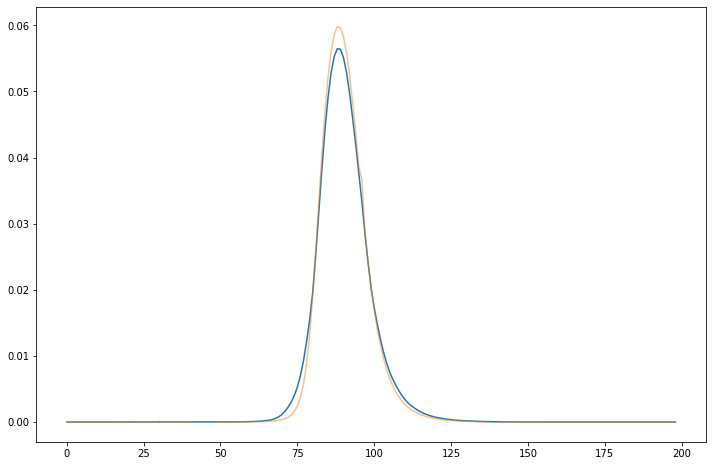

In [337]:
plt.plot(s)
plt.plot(df.values, alpha=.5)

In [292]:
res5.loc['SUR'].index.get_level_values('coverage_type').unique()

CategoricalIndex(['U'], categories=['N', 'A', 'U', 'R'], ordered=True, dtype='category', name='coverage_type')

In [50]:
df.index[0]

('PAK', 2000, 'N', 0)

In [51]:
def process(ser):
    idx = ser.index
    try:
        s_new = func(ser)
        s_new.index = idx
    except:
        print(idx[0])
        return pd.Series()
    return s_new

In [52]:
process(df)

country  year  coverage_type  bracket
PAK      2000  N              0           0.000000e+00
                              1           0.000000e+00
                              2          4.940656e-324
                              3          4.940656e-324
                              4          4.940656e-324
                                             ...      
                              194         9.457467e-10
                              195         6.099754e-10
                              196         3.764365e-10
                              197         2.204129e-10
                              198         1.213123e-10
Length: 199, dtype: float64

In [53]:
from multiprocessing import Pool

In [54]:
d1 = gs.get_group(('PAK', 2000, 'N'))
d2 = gs.get_group(('USA', 2000, 'N'))

In [55]:
with Pool(7) as p:
    res6 = p.map(process, [d1, d2])

In [56]:
pd.concat(res6)

country  year  coverage_type  bracket
PAK      2000  N              0           0.000000e+00
                              1           0.000000e+00
                              2          4.940656e-324
                              3          4.940656e-324
                              4          4.940656e-324
                                             ...      
USA      2000  N              194         6.468461e-07
                              195         3.215924e-07
                              196         1.373022e-07
                              197         4.576742e-08
                              198         9.153483e-09
Length: 398, dtype: float64

In [57]:
to_smooth = list()
for g, df in gs:
    to_smooth.append(df)

In [58]:
len(to_smooth)

6639

In [59]:
with Pool(11) as p:
    res6 = p.map(process, to_smooth)

/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


('CHN', 1981, 'A', 0)


<ipython-input-51-b66fb3d3fe6b>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series()


('CHN', 1981, 'R', 0)


/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


('CHN', 1986, 'A', 0)
('CHN', 1986, 'U', 0)


/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


('SUR', 1982, 'U', 0)


<ipython-input-51-b66fb3d3fe6b>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series()


('SWZ', 1981, 'N', 0)


<ipython-input-51-b66fb3d3fe6b>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series()


('SWZ', 1982, 'N', 0)
('SWZ', 1983, 'N', 0)
('SWZ', 1984, 'N', 0)
('SWZ', 1985, 'N', 0)
('SUR', 1984, 'U', 0)
('SUR', 1990, 'U', 0)
('SWZ', 2000, 'N', 0)
('SUR', 1999, 'U', 0)
('SUR', 2019, 'U', 0)


In [72]:
missing = [
    ('CHN', 1981, 'A'),
    ('CHN', 1981, 'R'),
    ('CHN', 1986, 'A'),
    ('CHN', 1986, 'U'),
    ('SUR', 1982, 'U'),
    ('SWZ', 1981, 'N'),
    ('SWZ', 1982, 'N'),
    ('SWZ', 1983, 'N'),
    ('SWZ', 1984, 'N'),
    ('SWZ', 1985, 'N'),
    ('SUR', 1984, 'U'),
    ('SUR', 1990, 'U'),
    ('SWZ', 2000, 'N'),
    ('SUR', 1999, 'U'),
    ('SUR', 2019, 'U'),
]

In [75]:
t = gs.get_group(('SUR', 1982, 'U'))
t

country  year  coverage_type  bracket
SUR      1982  U              0          0.000000
                              1          0.003542
                              2          0.000000
                              3          0.000000
                              4          0.000000
                                           ...   
                              194        0.000000
                              195        0.000000
                              196        0.000000
                              197        0.000000
                              198        0.000000
Name: HeadCount, Length: 199, dtype: float64

In [78]:
t.hasnans

False

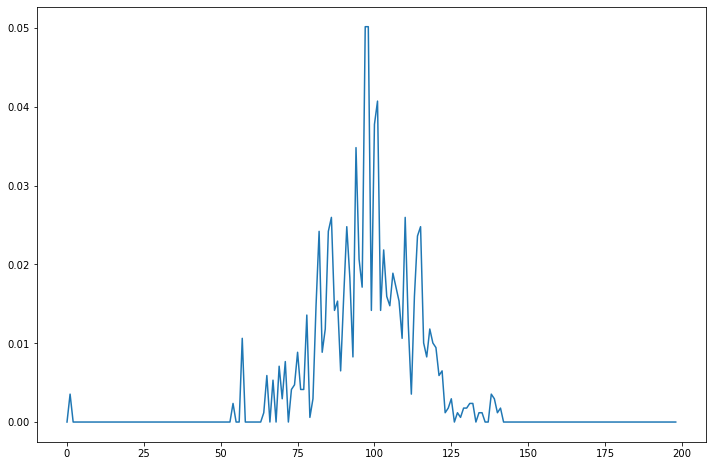

In [77]:
plt.plot(t.values)

In [86]:
run_smooth = smoothlib.run_smooth

In [87]:
func(t)

0      0.000015
1      0.000017
2      0.000019
3      0.000021
4      0.000023
         ...   
194    0.000000
195    0.000000
196    0.000000
197    0.000000
198    0.000000
Length: 199, dtype: float64

In [88]:
for g in missing:
    print(g)
    t = gs.get_group(g)
    func(t)

('CHN', 1981, 'A')
('CHN', 1981, 'R')
('CHN', 1986, 'A')
('CHN', 1986, 'U')
('SUR', 1982, 'U')
('SWZ', 1981, 'N')
('SWZ', 1982, 'N')
('SWZ', 1983, 'N')
('SWZ', 1984, 'N')
('SWZ', 1985, 'N')
('SUR', 1984, 'U')
('SUR', 1990, 'U')
('SWZ', 2000, 'N')
('SUR', 1999, 'U')
('SUR', 2019, 'U')


In [93]:
res7 = [x for x in res6 if not x.empty]

In [94]:
for g in missing:
    # print(g)
    t = gs.get_group(g)
    res7.append(process(t))

In [95]:
res7 = pd.concat(res7)

In [96]:
res7

country  year  coverage_type  bracket
AGO      1981  N              0           1.502705e-05
                              1           1.777000e-05
                              2           2.081764e-05
                              3           2.411089e-05
                              4           2.775329e-05
                                             ...      
SUR      2019  U              194         0.000000e+00
                              195         0.000000e+00
                              196         0.000000e+00
                              197       -4.940656e-324
                              198         0.000000e+00
Length: 1321161, dtype: float64

In [98]:
res7.name = 'population_percentage'
res7 = res7.reset_index()

In [100]:
res7['country'] = res7['country'].map(str.lower)
res7['coverage_type'] = res7['coverage_type'].map(str.lower)

In [101]:
from ddf_utils.str import format_float_digits

In [102]:
from functools import partial

In [103]:
formattor = partial(format_float_digits, digits=6)

In [104]:
res7['population_percentage'] = res7['population_percentage'].map(formattor)

In [106]:
!mkdir ../wip/smoothmountain

In [107]:
res7.to_csv('../wip/smoothmountain/ddf--datapoints--population_percentage--by--country--year--coverage_type--bracket.csv', index=False)

In [2]:
# step 8: calculate shape

In [21]:
all_brackets = np.logspace(-7, 13, 200, endpoint=True, base=2)
brackets = pd.DataFrame({'start': all_brackets, 'end': pd.Series(all_brackets).shift(-1)})
brackets_log = brackets.iloc[:-1].copy()
brackets_log['start'] = np.log2(brackets_log['start'])
brackets_log['end'] = np.log2(brackets_log['end'])
brackets_log['d'] = brackets_log.end - brackets_log.start
delta = brackets_log['d'].iloc[0]

In [3]:
def bracket_number_from_income(s):
    return ((np.log2(s / 30) + 7) / delta).astype(int)

In [4]:
mean = pd.read_csv('../wip/mean_income-by-country-year-coverage_type.csv')

In [6]:
mean['Mean'].hasnans

True

In [30]:
res7 = pd.read_csv(
    '../wip/smoothmountain/ddf--datapoints--population_percentage--by--country--year--coverage_type--bracket.csv',
    dtype={'population_percentage': str})

In [16]:
mean = mean.set_index(['country', 'year', 'coverage_type'])

In [31]:
res7 = res7.set_index(['country', 'year', 'coverage_type'])

In [32]:
gs = res7.groupby(['country', 'year', 'coverage_type'])

In [33]:
res8 = []
for g, df in gs:
    df_ = df.copy()
    g_ = (g[0].upper(), g[1], g[2].upper())
    m = mean.loc[g_, 'Mean']
    b = bracket_number_from_income(m)
    df_['bracket'] = df_['bracket'] - b
    res8.append(df_)

In [34]:
res8 = pd.concat(res8)

In [35]:
res8

bracket population_percentage
country year coverage_type                               
ago     1981 n                  -94              0.000015
             n                  -93              0.000018
             n                  -92              0.000021
             n                  -91              0.000024
             n                  -90              0.000028
...                             ...                   ...
zwe     2019 n                  105              0.000001
             n                  106              0.000001
             n                  107                     0
             n                  108                     0
             n                  109                     0

[1321161 rows x 2 columns]

In [25]:
!mkdir ../wip/smoothshape

In [36]:
res8.to_csv('../wip/smoothshape/ddf--datapoints--population_percentage--by--country--year--coverage_type--bracket.csv')

In [42]:
res8 = res8.drop(columns=['index'])

In [43]:
# res8 = res8.reset_index()
res8.columns = ['country', 'year', 'coverage_type', 'relative_bracket', 'income_mountain_relative_bracket_shape_for_log']

In [44]:
res8.to_csv('../../ddf--datapoints--income_mountain_relative_bracket_shape_for_log--by--country--year--coverage_type--relative_bracket.csv')

In [29]:
res8

bracket  population_percentage
country year coverage_type                                
ago     1981 n                  -94               0.000015
             n                  -93               0.000018
             n                  -92               0.000021
             n                  -91               0.000024
             n                  -90               0.000028
...                             ...                    ...
zwe     2019 n                  105               0.000001
             n                  106               0.000001
             n                  107               0.000000
             n                  108               0.000000
             n                  109               0.000000

[1321161 rows x 2 columns]

In [49]:
coverage_type_dtype_2 = pd.CategoricalDtype(list('naur'), ordered=True)

In [50]:
res9 = res8.copy()
res9['coverage_type'] = res9['coverage_type'].astype(coverage_type_dtype_2)

In [54]:
res10 = res9.groupby(by=['country', 'year', 'relative_bracket']).first()

In [55]:
res10 = res10.drop(columns=['coverage_type'])

In [57]:
res10.to_csv('../../ddf--datapoints--income_mountain_relative_bracket_shape_for_log--by--country--year--relative_bracket.csv')

In [46]:
res7 = res7.reset_index()

In [80]:
res7.columns = ['country', 'year', 'coverage_type', 'income_bracket_200', 'income_mountain_200bracket_shape_for_log']

In [62]:
res11 = res7.copy()
res11['coverage_type'] = res11['coverage_type'].astype(coverage_type_dtype_2)

In [63]:
res12 = res11.groupby(by=['country', 'year', 'income_bracket_200']).first()

In [64]:
res12

coverage_type  \
country year income_bracket_200                 
ago     1981 0                              n   
             1                              n   
             2                              n   
             3                              n   
             4                              n   
...                                       ...   
zwe     2019 194                            n   
             195                            n   
             196                            n   
             197                            n   
             198                            n   

                                income_mountain_200_bracket_shape_for_log  
country year income_bracket_200                                            
ago     1981 0                                                   0.000015  
             1                                                   0.000018  
             2                                                   0.000021  
             3                                                   0.000024  
             4                                                   0.000028  
...                                                                   ...  
zwe     2019 194                                                 0.000001  
             195                                                 0.000001  
             196                                                        0  
             197                                                        0  
             198                                                        0  

[1275391 rows x 2 columns]

In [65]:
res12 = res12.drop(columns=['coverage_type'])

In [83]:
res12.columns = ['income_mountain_200bracket_shape_for_log']

In [84]:
res12.to_csv('../../ddf--datapoints--income_mountain_200bracket_shape_for_log--by--country--year--income_bracket_200.csv')

In [ ]:
# some more files for bracket entities

In [69]:
rb = pd.DataFrame({'relative_bracket': range(-200, 200), 'name': range(-200, 200)})

In [71]:
rb = rb.set_index('relative_bracket')

In [72]:
rb.to_csv('../../ddf--entities--relative_bracket.csv')

In [ ]:
# testing blending

In [93]:
c = 'income_mountain_relative_bracket_shape_for_log'

In [100]:
res8[c] = res8[c].astype(float)

In [101]:
gs = res8.groupby(['country', 'year', 'coverage_type'])

In [129]:
s1 = gs.get_group(('rus', 1999, 'n')).set_index('relative_bracket')[c]
s2 = gs.get_group(('mus', 2004, 'n')).set_index('relative_bracket')[c]
s3_expect = gs.get_group(('chn', 2016, 'a')).set_index('relative_bracket')[c]

In [133]:
s1_, s2_ = s1.align(s2)
s1_ = s1_.fillna(0)
s2_ = s2_.fillna(0)
s3 = (s1 + s2) / 2

In [139]:
new_idx = s3.index.values + 102
s3.index = pd.Index(new_idx)

In [140]:
new_idx = s3_expect.index.values + 102
s3_expect.index = pd.Index(new_idx)

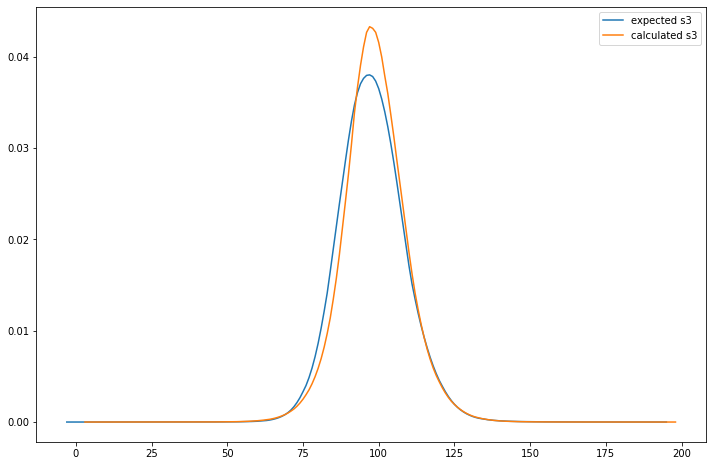

In [141]:
# plt.plot(s1[c], label='s1')
# plt.plot(s2[c], label='s2')
plt.plot(s3_expect, label='expected s3')
plt.plot(s3, label='calculated s3')
plt.legend()

In [125]:
m1 = mean.loc[('RUS', 1999, 'N')]
m2 = mean.loc[('MUS', 2004, 'N')]
m3_expect = mean.loc[('CHN', 2016, 'A')]

In [126]:
m1

Mean    237.8055
Name: (RUS, 1999, N), dtype: float64

In [127]:
m2

Mean    304.8702
Name: (MUS, 2004, N), dtype: float64

In [128]:
m3_expect

Mean    353.8384
Name: (CHN, 2016, A), dtype: float64

In [177]:
gs = res8.groupby(['country', 'year', 'coverage_type'])

def get_data(x):
    return gs.get_group(x).set_index('relative_bracket')[c]

def get_mean(x):
    return mean.loc[(x[0].upper(), x[1], x[2].upper()), 'Mean']

def do_average(s1, s2):
    s1_, s2_ = s1.align(s2)
    s1_ = s1_.fillna(0)
    s2_ = s2_.fillna(0)
    s3 = (s1_ + s2_) / 2
    return s3

def reset_x_axis(x_, m):
    x = x_.copy()
    mb = bracket_number_from_income(m)
    new_idx = x.index.values + mb
    x.index = pd.Index(new_idx)
    return x

def trying(x, neighbors):
    s3_expect = get_data(x)
    m_expect = get_mean(x)
    
    mean = [get_mean(neighbors[0])]
    s3 = get_data(neighbors[0])
    for n in neighbors[1:]:
        s3 = do_average(s3, get_data(n))
        mean.append(get_mean(n))
        
    mean = np.sum(mean) / len(mean)
    print(mean, m_expect)
        
    return reset_x_axis(s3, mean), reset_x_axis(s3_expect, m_expect)

In [187]:
x = ('eth', 2011, 'n')
neighbors = [
    ('sle', 2011, 'n'),
    ('lbr', 2011, 'n'),
    ('chn', 1990, 'a')
]

s3, s3_expect = trying(x, neighbors)

63.66188 86.00532


In [188]:
bracket_number_from_income(63)

80

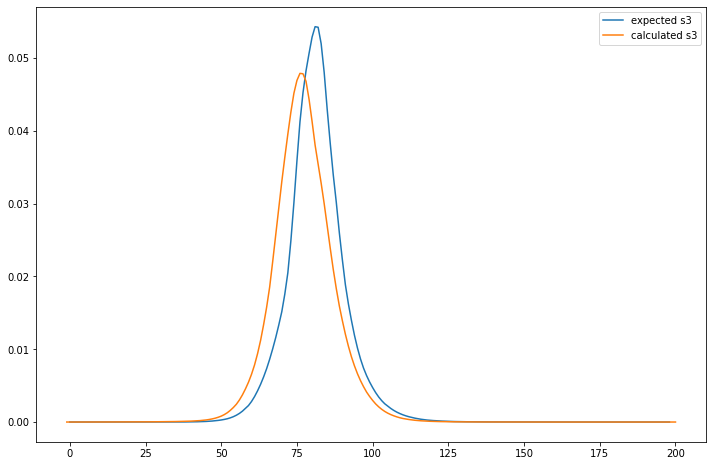

In [189]:
plt.plot(s3_expect, label='expected s3')
plt.plot(s3, label='calculated s3')
plt.legend()

In [170]:
# great example (high gini)

x = ('bra', 1990, 'n')
neighbors = [
    ('pan', 1990, 'n'),
    ('bwa', 1996, 'n'),
    ('nam', 2014, 'n')
]

In [182]:
# low gini, not very good
x = ('eth', 2011, 'n')
neighbors = [
    ('sle', 2011, 'n'),
    ('lbr', 2011, 'n'),
    ('chn', 1990, 'a')
]